In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import sys
import pickle
import blip_analysis as ba
import exp_blip_models as em
from scipy.cluster.hierarchy import dendrogram, linkage
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe

from scipy.stats import ttest_ind
import importlib
importlib.reload(em)
importlib.reload(ba)

b
b


<module 'blip_analysis' from '/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/blip_analysis.py'>

In [8]:
dasked = daskify.Daskified()


In [9]:
dasked.start_cluster()

In [10]:
client = dasked.client

In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()

Found odour 1
Found odour 3
Found odour 5


In [3]:
glyphs = ba.get_glyphs()
good_indexes = ba.get_stable_resp_indexes()

In [4]:
full_models1 = pickle.Unpickler(open('../Fig3/221209_full_models1.pkl', 'rb')).load()
full_models2 = pickle.Unpickler(open('../Fig3/221209_full_models2.pkl', 'rb')).load()
full_models3 = pickle.Unpickler(open('../Fig3/221209_full_models3.pkl', 'rb')).load()

In [8]:
def dask_fit_splitter(input_name, model_index):
    models = pickle.Unpickler(open(input_name, 'rb')).load()
    model = models[model_index]
    model.fit_split()
    return model

In [9]:
delayeds = [dask.delayed(dask_fit_splitter)('../Fig3/221209_full_models1.pkl', i) for i in range(145)]


In [11]:
dask_outs = client.compute(delayeds)
dasked.current_futures = dask_outs
dasked.check_progress()

pending 145


In [14]:
dasked.check_progress()

pending 145


In [23]:
full_models1 = [i.result() for i in dask_outs]

In [5]:
bins1 = np.array([i.opt_out.x[:-1] for i in full_models1])[good_indexes]
bins2 = np.array([i.opt_out.x[:-1] for i in full_models2])[good_indexes]
bins3 = np.array([i.opt_out.x[:-1] for i in full_models3])[good_indexes]
all_bins = np.concatenate([bins1, bins2, bins3], axis=1)
full_max = np.max(np.abs([bins1, bins2, bins3]))



In [6]:
pca1 = PCA(n_components=9)
pcad1 = pca1.fit_transform(bins1)
pca2 = PCA(n_components=9)
pcad2 = pca2.fit_transform(bins2)
pca3 = PCA(n_components=9)
pcad3 = pca3.fit_transform(bins3)
pca_all = PCA(n_components=9)
pcad_all = pca_all.fit_transform(np.concatenate([bins1, bins2, bins3], axis=0))

In [12]:
model = full_models1[0]
ys = [i for j in range(60) for i in range(32)]

In [11]:
def dask_svm(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    return pred, y_test

def generate_noisy_data(models, noise_level=10,repeats=60, method='add', unit_var_scale=1):
    all_pred_firings = []
    trial_array1 = np.append(models[0].trial_array, np.ones((32, 1)), axis=1)
    for model in models:
        pred_firings= []
        if len(model.pred_resp) != 32:
            model.fit()
        for i in range(repeats):
            if method == 'add':
                pred_firing  = model.pred_resp + norm.rvs(0, noise_level, size=32)
            elif method == 'unit_var':
                pred_firing = model.pred_resp + np.array([norm.rvs(0, j, size=1)[0]*unit_var_scale for j in model.unit_sr_var])
            pred_firings.append(pred_firing)
        all_pred_firings.append(pred_firings)
    all_pred_firings = np.array(all_pred_firings)
#    ys = [i for j in range(60) for i in range(32)]
    return all_pred_firings

def generate_and_dask(models, noise_level=10, repeats=100, method='unit_var', unit_var_scale=1, wait=True):
    X = generate_noisy_data(models, noise_level=noise_level, method=method, unit_var_scale=unit_var_scale).reshape(len(models), -1).T
    X_scattered = client.scatter(X)
    delayeds = [dask.delayed(dask_svm)(X_scattered, y_scatter, 32) for i in range(repeats)]
    dask_outs = client.compute(delayeds)
    if wait:
        res = np.array([i.result() for i in dask_outs])
        cm = confusion_matrix(res[:, 1].reshape(-1), res[:, 0].reshape(-1), labels=range(32), normalize='true')
        return res, cm
    else:
        return dask_outs

In [11]:
X_1 = generate_noisy_data(full_models1, noise_level=1).reshape(145, -1).T
X_3 = generate_noisy_data(full_models1, noise_level=3).reshape(145, -1).T
X_5 = generate_noisy_data(full_models1, noise_level=5).reshape(145, -1).T
X_10 = generate_noisy_data(full_models1, noise_level=10).reshape(145, -1).T
X_20 = generate_noisy_data(full_models1, noise_level=20).reshape(145, -1).T
X_25 = generate_noisy_data(full_models1, noise_level=25).reshape(145, -1).T

In [12]:
X_1_scatter = client.scatter(X_1)
X_3_scatter = client.scatter(X_3)
X_5_scatter = client.scatter(X_5)
X_10_scatter = client.scatter(X_10)
X_20_scatter = client.scatter(X_20)
X_25_scatter = client.scatter(X_25)

In [19]:
delayeds_1 = [dask.delayed(dask_svm)(X_1_scatter, y_scatter, 32) for i in range(100)]
delayeds_3 = [dask.delayed(dask_svm)(X_3_scatter, y_scatter, 32) for i in range(100)]
delayeds_5 = [dask.delayed(dask_svm)(X_5_scatter, y_scatter, 32) for i in range(100)]
delayeds_10 = [dask.delayed(dask_svm)(X_10_scatter, y_scatter, 32) for i in range(100)]
delayeds_20 = [dask.delayed(dask_svm)(X_20_scatter, y_scatter, 32) for i in range(100)]
delayeds_25 = [dask.delayed(dask_svm)(X_25_scatter, y_scatter, 32) for i in range(100)]

In [20]:
dask_outs_1 = client.compute(delayeds_1)
dask_outs_3 = client.compute(delayeds_3)
dask_outs_5 = client.compute(delayeds_5)
dask_outs_10 = client.compute(delayeds_10)
dask_outs_20 = client.compute(delayeds_20)
dask_outs_25 = client.compute(delayeds_25)

In [22]:
X_uv = generate_noisy_data(full_models1, method='unit_var', unit_var_scale=0.3).reshape(145, -1).T
X_uv_scatter = client.scatter(X_uv)
delayed_uv = [dask.delayed(dask_svm)(X_uv_scatter, y_scatter, 32) for i in range(100)]
dask_outs_uv = client.compute(delayed_uv)
dasked.current_futures = dask_outs_uv

In [18]:
X = all_pred_firings.reshape(145, -1).T
X_scatter = client.scatter(X)
y_scatter = client.scatter(ys)

NameError: name 'all_pred_firings' is not defined

In [19]:
ys = [i for j in range(60) for i in range(32)]
y_scatter = client.scatter(ys)

In [292]:
delayeds = [dask.delayed(dask_svm)(X_scatter, y_scatter, 32) for i in range(100)]

In [293]:
dask_outs = client.compute(delayeds)

In [361]:
dasked.current_futures = dask_outs_1

In [418]:
dasked.check_progress()

pending 100


In [21]:
res_1 = np.array([i.result() for i in dask_outs_1])
res_3 = np.array([i.result() for i in dask_outs_3])
res_5 = np.array([i.result() for i in dask_outs_5])
res_10 = np.array([i.result() for i in dask_outs_10])
res_20 = np.array([i.result() for i in dask_outs_20])
res_25 = np.array([i.result() for i in dask_outs_25])

In [23]:
res_uv = np.array([i.result() for i in dask_outs_uv])

In [19]:
def plot_cm(res):
    cm = confusion_matrix(res[:, 1].reshape(-1), res[:, 0].reshape(-1), labels=range(32), normalize='true')
    plt.imshow(cm)
    plt.colorbar()

In [30]:
cm_1 = confusion_matrix(res_1[:, 1].reshape(-1), res_1[:, 0].reshape(-1), labels=range(32), normalize='true')
cm_3 = confusion_matrix(res_3[:, 1].reshape(-1), res_3[:, 0].reshape(-1), labels=range(32), normalize='true')
cm_5 = confusion_matrix(res_5[:, 1].reshape(-1), res_5[:, 0].reshape(-1), labels=range(32), normalize='true')
cm_10 = confusion_matrix(res_10[:, 1].reshape(-1), res_10[:, 0].reshape(-1), labels=range(32), normalize='true')
cm_20 = confusion_matrix(res_20[:, 1].reshape(-1), res_20[:, 0].reshape(-1), labels=range(32), normalize='true')
cm_uv = confusion_matrix(res_uv[:, 1].reshape(-1), res_uv[:, 0].reshape(-1), labels=range(32), normalize='true')

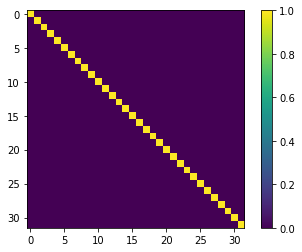

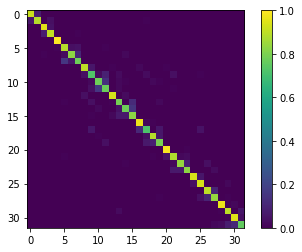

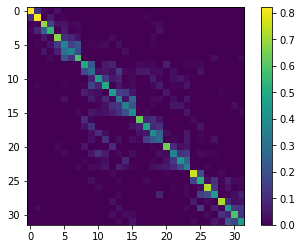

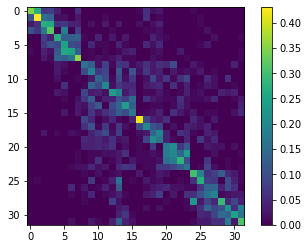

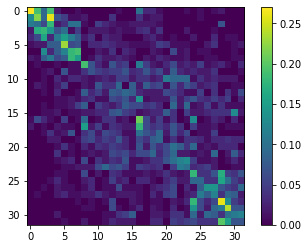

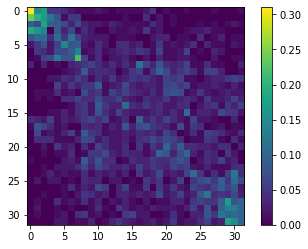

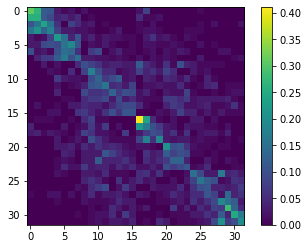

In [26]:
plt.figure()
plot_cm(res_1)
plt.figure()
plot_cm(res_3)
plt.figure()
plot_cm(res_5)
plt.figure()
plot_cm(res_10)
plt.figure()
plot_cm(res_20)
plt.figure()
plot_cm(res_25)
plt.figure()
plot_cm(res_uv)

In [7]:
all_reses = np.load('../Fig2/221027_all_svm_outs.npy')
preds1 = np.array(all_reses)[0, :, 0].reshape(500, 32)
trues1 = np.array(all_reses)[0, :, 1].reshape(500, 32)
preds2 = np.array(all_reses)[1, :, 0].reshape(500, 32)
trues2 = np.array(all_reses)[1, :, 1].reshape(500, 32)
preds3 = np.array(all_reses)[2, :, 0].reshape(500, 32)
trues3 = np.array(all_reses)[2, :, 1].reshape(500, 32)
cm1 = confusion_matrix(np.concatenate(trues1), np.concatenate(preds1), normalize='true', labels=range(32))
cm2 = confusion_matrix(np.concatenate(trues2), np.concatenate(preds2), normalize='true', labels=range(32))
cm3 = confusion_matrix(np.concatenate(trues3), np.concatenate(preds3), normalize='true', labels=range(32))

In [31]:
cm_diff = cm1 - cm_1

In [38]:
diffs = [np.sum(abs(cm1 - cm_1)), 
         np.sum(abs(cm1 - cm_3)),
         np.sum(abs(cm1 - cm_5)),
         np.sum(abs(cm1 - cm_10)),
         np.sum(abs(cm1 - cm_20)),
         np.sum(abs(cm1 - cm_uv))]

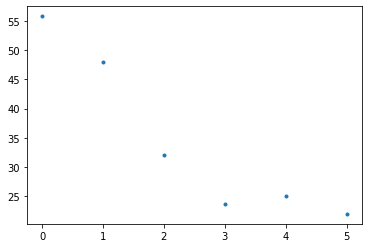

In [39]:
plt.plot(diffs, '.')
plt.xticks(range(6), labels=[1, 3, 5, 10, 20, 'Unit variance'])
plt.ylabel('Cummulative difference')
plt.xlabel('Noise levels')

In [ ]:
res_5, cm_5 = generate_and_dask(full_models1, 5)
res_5, cm_5 = generate_and_dask(full_models1, 6)
res_5, cm_5 = generate_and_dask(full_models1, 7)
res_5, cm_5 = generate_and_dask(full_models1, 8)
res_5, cm_5 = generate_and_dask(full_models1, 9)

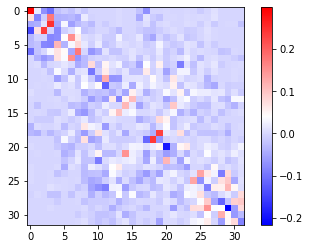

In [42]:
plt.imshow(cm1-cm_uv, cmap='bwr')
plt.colorbar()

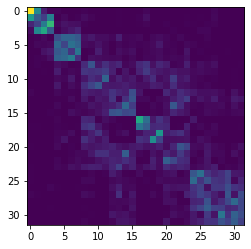

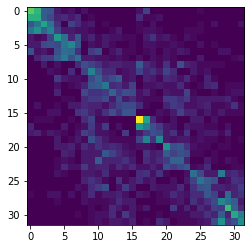

In [43]:
plt.imshow(cm1)
plt.figure()
plt.imshow(cm_uv)

In [63]:
res_uv_10, cm_uv_10 = generate_and_dask(full_models1)
res_uv_5, cm_uv_5 = generate_and_dask(full_models1, unit_var_scale=0.5)
res_uv_4, cm_uv_4 = generate_and_dask(full_models1, unit_var_scale=0.4)
res_uv_3, cm_uv_3 = generate_and_dask(full_models1, unit_var_scale=0.3)
res_uv_2, cm_uv_2 = generate_and_dask(full_models1, unit_var_scale=0.2)
res_uv_1, cm_uv_1 = generate_and_dask(full_models1, unit_var_scale=0.1)

In [64]:
res_uv_15, cm_uv_15 = generate_and_dask(full_models1, unit_var_scale=0.15)
print(5)
res_uv_16, cm_uv_16 = generate_and_dask(full_models1, unit_var_scale=0.16)
print(6)
res_uv_17, cm_uv_17 = generate_and_dask(full_models1, unit_var_scale=0.17)
print(7)
res_uv_18, cm_uv_18 = generate_and_dask(full_models1, unit_var_scale=0.18)
print(8)
res_uv_19, cm_uv_19 = generate_and_dask(full_models1, unit_var_scale=0.19)
print(9)
res_uv_21, cm_uv_21 = generate_and_dask(full_models1, unit_var_scale=0.21)
print(10)
res_uv_22, cm_uv_22 = generate_and_dask(full_models1, unit_var_scale=0.22)
print(11)
res_uv_23, cm_uv_23 = generate_and_dask(full_models1, unit_var_scale=0.23)
print(12)
res_uv_24, cm_uv_24 = generate_and_dask(full_models1, unit_var_scale=0.24)
print(13)
res_uv_25, cm_uv_25 = generate_and_dask(full_models1, unit_var_scale=0.25)
print('done')

5
6
7
8
9
10
11
12
13
done


In [65]:
diffs = [np.sum(abs(cm1 - cm_uv_1)),
         np.sum(abs(cm1 - cm_uv_15)),
         np.sum(abs(cm1 - cm_uv_16)),
         np.sum(abs(cm1 - cm_uv_17)),
         np.sum(abs(cm1 - cm_uv_18)),
         np.sum(abs(cm1 - cm_uv_19)),
         np.sum(abs(cm1 - cm_uv_2)),
         np.sum(abs(cm1 - cm_uv_21)),
         np.sum(abs(cm1 - cm_uv_22)),
         np.sum(abs(cm1 - cm_uv_23)),
         np.sum(abs(cm1 - cm_uv_24)),
         np.sum(abs(cm1 - cm_uv_25)),
         np.sum(abs(cm1 - cm_uv_3)),
         np.sum(abs(cm1 - cm_uv_4)),
         np.sum(abs(cm1 - cm_uv_5)),
         np.sum(abs(cm1 - cm_uv_10))]

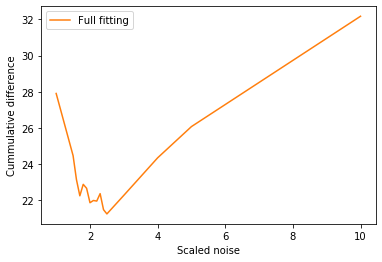

In [67]:
plt.plot([1, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 3, 4, 5, 10], diffs, color='C1', label='Full fitting')
plt.ylabel('Cummulative difference')
plt.xlabel('Scaled noise')

plt.legend()

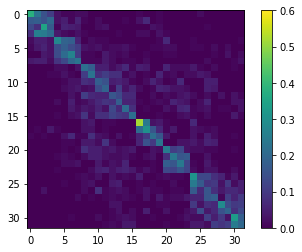

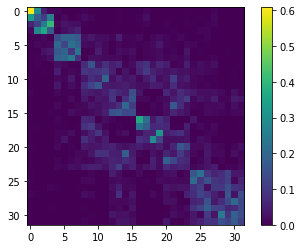

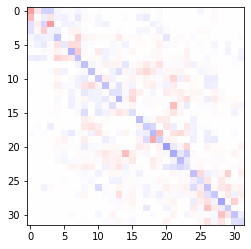

In [68]:
plt.imshow(cm_uv_2, vmax=0.6)
plt.colorbar()
plt.figure()
plt.imshow(cm1)
plt.colorbar()
plt.figure()
plt.imshow(cm1-cm_uv_2, vmin=-0.6, vmax=0.6, cmap='bwr')

Text(0.5, 1.0, 'True - modelled')

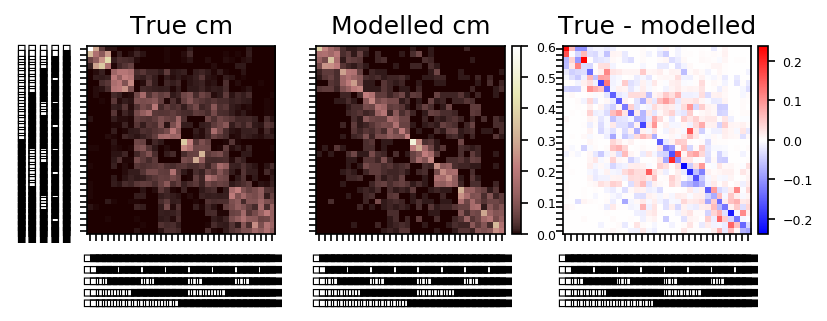

In [125]:
fig = plt.figure(dpi=150)
gs = GridSpec(1, 3)
sub_gs = gs[:2].subgridspec(1, 2,)
ax1 = fig.add_subplot(sub_gs[0])
ax1.set_xticks(range(32))
ax1.set_yticks(range(32))
ax1.set_xticklabels(glyphs, rotation=90)
ax1.set_yticklabels(glyphs)

ax2 = fig.add_subplot(sub_gs[1])
ax2.set_yticks(range(32))
ax2.set_yticklabels([])
ax2.set_xticks(range(32))
ax2.set_xticklabels(glyphs, rotation=90)
ax3 = fig.add_subplot(gs[2])
ax3.set_xticks(range(32))
ax3.set_yticks(range(32))
ax3.set_xticklabels(glyphs, rotation=90)
ax3.set_yticklabels([])
ax1.imshow(cm1, cmap='pink',vmax=0.6, aspect=1)
im = ax2.imshow(cm_uv_2, cmap='pink', vmax=0.6)
vmax = np.max(abs(cm1-cm_uv_2))
im_diff = ax3.imshow(cm1-cm_uv_2, cmap='bwr', vmin=-vmax, vmax=vmax)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(ax1)
_ = divider.append_axes('left', size='5%', pad=0.05, frameon=False)
_.set_xticks([])
_.set_yticks([])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=6)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im_diff, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax1.set_title('True cm')
ax2.set_title('Modelled cm')
ax3.set_title('True - modelled')

In [12]:
def plot_true_and_heatmap_difference(fig, global_gs, cm_true, cm_modelled):
    gs = global_gs.subgridspec(1, 3)
    sub_gs = gs[:2].subgridspec(1, 2,)
    ax1 = fig.add_subplot(sub_gs[0])
    ax1.set_xticks(range(32))
    ax1.set_yticks(range(32))
    ax1.set_xticklabels(glyphs, rotation=90)
    ax1.set_yticklabels(glyphs)

    ax2 = fig.add_subplot(sub_gs[1])
    ax2.set_yticks(range(32))
    ax2.set_yticklabels([])
    ax2.set_xticks(range(32))
    ax2.set_xticklabels(glyphs, rotation=90)
    ax3 = fig.add_subplot(gs[2])
    ax3.set_xticks(range(32))
    ax3.set_yticks(range(32))
    ax3.set_xticklabels(glyphs, rotation=90)
    ax3.set_yticklabels([])
    ax1.imshow(cm1, cmap='pink',vmax=0.6, aspect=1)
    im = ax2.imshow(cm_modelled, cmap='pink', vmax=0.6)
    vmax = np.max(abs(cm1-cm_modelled))
    im_diff = ax3.imshow(cm1-cm_modelled, cmap='bwr', vmin=-vmax, vmax=vmax)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    divider = make_axes_locatable(ax1)
    _ = divider.append_axes('left', size='5%', pad=0.05, frameon=False)
    _.set_xticks([])
    _.set_yticks([])
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=6)

    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im_diff, cax=cax)
    cbar.ax.tick_params(labelsize=6)

    ax1.set_title('True cm')
    ax2.set_title('Modelled cm')
    ax3.set_title('True - modelled')

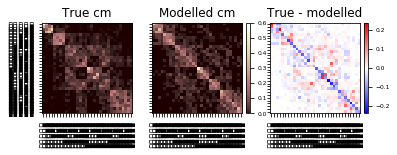

In [127]:
fig = plt.figure()
gs = GridSpec(1, 1)
plot_true_and_heatmap_difference(fig, gs[0], cm1, cm_uv_05)

In [45]:
### Doing the single pc
blanked_pcad1 = pcad1.copy()
blanked_models1 = deepcopy(full_models1)
blanked_models1 = np.array(blanked_models1)[good_indexes]
blanked_pcad1[:, 1:] = 0
blanked_inv = pca1.inverse_transform(blanked_pcad1)
blanked_inv = np.append(blanked_inv, np.array([model.opt_out.x[-1] for model in blanked_models1])[:, np.newaxis], axis=-1)


blanked_pcad1_2 = pcad1.copy()
blanked_models1_2 = deepcopy(full_models1)
blanked_models1_2 = np.array(blanked_models1_2)[good_indexes]
blanked_pcad1_2[:, 2:] = 0
blanked_inv_2 = pca1.inverse_transform(blanked_pcad1_2)
blanked_inv_2 = np.append(blanked_inv_2, np.array([model.opt_out.x[-1] for model in blanked_models1_2])[:, np.newaxis], axis=-1)

blanked_pcad1_3 = pcad1.copy()
blanked_models1_3 = deepcopy(full_models1)
blanked_models1_3 = np.array(blanked_models1_3)[good_indexes]
blanked_pcad1_3[:, 3:] = 0
blanked_inv_3 = pca1.inverse_transform(blanked_pcad1_3)
blanked_inv_3 = np.append(blanked_inv_3, np.array([model.opt_out.x[-1] for model in blanked_models1_3])[:, np.newaxis], axis=-1)

blanked_pcad1_4 = pcad1.copy()
blanked_models1_4 = deepcopy(full_models1)
blanked_models1_4 = np.array(blanked_models1_4)[good_indexes]
blanked_pcad1_4[:, 4:] = 0
blanked_inv_4 = pca1.inverse_transform(blanked_pcad1_4)
blanked_inv_4 = np.append(blanked_inv_4, np.array([model.opt_out.x[-1] for model in blanked_models1_4])[:, np.newaxis], axis=-1)

blanked_pcad1_5 = pcad1.copy()
blanked_models1_5 = deepcopy(full_models1)
blanked_models1_5 = np.array(blanked_models1_5)[good_indexes]
blanked_pcad1_5[:, 5:] = 0
blanked_inv_5 = pca1.inverse_transform(blanked_pcad1_5)
blanked_inv_5 = np.append(blanked_inv_5, np.array([model.opt_out.x[-1] for model in blanked_models1_5])[:, np.newaxis], axis=-1)

blanked_pcad1_6 = pcad1.copy()
blanked_models1_6 = deepcopy(full_models1)
blanked_models1_6 = np.array(blanked_models1_6)[good_indexes]
blanked_pcad1_6[:, 6:] = 0
blanked_inv_6 = pca1.inverse_transform(blanked_pcad1_6)
blanked_inv_6 = np.append(blanked_inv_6, np.array([model.opt_out.x[-1] for model in blanked_models1_6])[:, np.newaxis], axis=-1)

blanked_pcad1_7 = pcad1.copy()
blanked_models1_7 = deepcopy(full_models1)
blanked_models1_7 = np.array(blanked_models1_7)[good_indexes]
blanked_pcad1_7[:, 4:] = 0
blanked_inv_7 = pca1.inverse_transform(blanked_pcad1_7)
blanked_inv_7 = np.append(blanked_inv_7, np.array([model.opt_out.x[-1] for model in blanked_models1_7])[:, np.newaxis], axis=-1)

blanked_pcad1_8 = pcad1.copy()
blanked_models1_8 = deepcopy(full_models1)
blanked_models1_8 = np.array(blanked_models1_8)[good_indexes]
blanked_pcad1_8[:, 8:] = 0
blanked_inv_8 = pca1.inverse_transform(blanked_pcad1_8)
blanked_inv_8 = np.append(blanked_inv_8, np.array([model.opt_out.x[-1] for model in blanked_models1_8])[:, np.newaxis], axis=-1)


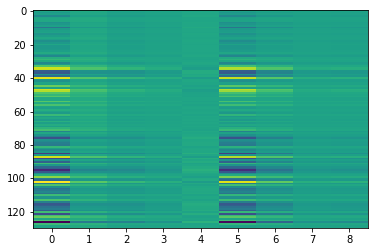

In [32]:
plt.imshow(blanked_inv[:, :-1], aspect='auto')

In [14]:
def remove_pcs(models, pcs_to_keep=1):

    bins = np.array([[i.x[:-1] for i in model.training_opts] for model in models])

    bins = np.moveaxis(bins, 0, 1)
    bins_bl = []
    print(bins.shape)
    for bin_set in bins:
        pca = PCA(n_components=9)
        pcad_weights = pca.fit_transform(bin_set)
        pcad_weights[:, pcs_to_keep:] = 0
        bin_set_bl = pca.inverse_transform(pcad_weights)



        bins_bl.append(bin_set_bl)
    bins_bl = np.array(bins_bl)
    threshes =  np.array([[i.x[-1] for i in model.training_opts] for model in models]).T
    threshes = threshes[:, :, np.newaxis]

    bins_bl = np.append(bins_bl,  threshes, axis=-1)
    bins_bl = np.moveaxis(bins_bl, 0, 1)
    return bins_bl
#    print(bins.shape)

#     pcad_weights = pca.fit_transform(bins)
#     print(pcad_weights.shape)

bins_bl = remove_pcs(np.array(full_models1)[good_indexes])
bins_bl2 = remove_pcs(np.array(full_models1)[good_indexes], pcs_to_keep=2)
print(bins_bl.shape)
#bins_bl = bins_bl[good_indexes]

AttributeError: 'ExponentialCustomTrialArray' object has no attribute 'training_opts'

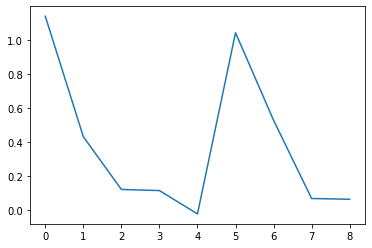

In [112]:
plt.plot(bins_bl[40, 0, :-1])

In [21]:
blanked_inv_2.shape

(130, 10)

In [100]:
model = full_models1[0]
print(len(model.pred_resp))

32


In [ ]:
[model.fit() for i in full_models1];

In [35]:
[blanked_models1[i].fit(W=blanked_inv[i]) for i in range(130)];
[blanked_models1_2[i].fit(W=blanked_inv_2[i]) for i in range(130)];
[blanked_models1_3[i].fit(W=blanked_inv_2[i]) for i in range(130)];
[blanked_models1_4[i].fit(W=blanked_inv_2[i]) for i in range(130)];


In [36]:
res_blanked, cm_blanked1 = generate_and_dask(blanked_models1, method='unit_var', unit_var_scale=0.2)
print('1')
res_blanked, cm_blanked2 = generate_and_dask(blanked_models1_2, method='unit_var', unit_var_scale=0.2)
print(2)
res_blanked, cm_blanked3 = generate_and_dask(blanked_models1_3, method='unit_var', unit_var_scale=0.2)
print(3)
res_blanked, cm_blanked4 = generate_and_dask(blanked_models1_4, method='unit_var', unit_var_scale=0.2)

1
2
3


In [46]:
res_blanked, cm_blanked5 = generate_and_dask(blanked_models1_5, method='unit_var', unit_var_scale=0.2)
print(5)
res_blanked, cm_blanked6 = generate_and_dask(blanked_models1_6, method='unit_var', unit_var_scale=0.2)
print(6)
res_blanked, cm_blanked7 = generate_and_dask(blanked_models1_7, method='unit_var', unit_var_scale=0.2)
print(7)
res_blanked, cm_blanked8 = generate_and_dask(blanked_models1_8, method='unit_var', unit_var_scale=0.2)


5
6
7


In [26]:
res_blanked, cm_blanked2 = generate_and_dask(blanked_models1_2, method='unit_var', unit_var_scale=0.2)


NameError: name 'y_scatter' is not defined

In [92]:
dask_pc1_00 = generate_and_dask(blanked_models1, method='unit_var', unit_var_scale=0.0)
dask_pc1_05 = generate_and_dask(blanked_models1, method='unit_var', unit_var_scale=0.05)
dask_pc1_10 = generate_and_dask(blanked_models1, method='unit_var', unit_var_scale=0.1)
dask_pc1_15 = generate_and_dask(blanked_models1, method='unit_var', unit_var_scale=0.15)
dask_pc1_20 = generate_and_dask(blanked_models1, method='unit_var', unit_var_scale=0.2)
dask_pc1_25 = generate_and_dask(blanked_models1, method='unit_var', unit_var_scale=0.25)
dask_pc1_30 = generate_and_dask(blanked_models1, method='unit_var', unit_var_scale=0.3)


finished 145


In [95]:
cm_pc1_00 = dask_pc1_00[1]
cm_pc1_05 = dask_pc1_05[1]
cm_pc1_10 = dask_pc1_10[1]
cm_pc1_15 = dask_pc1_15[1]
cm_pc1_20 = dask_pc1_20[1]
cm_pc1_25 = dask_pc1_25[1]
cm_pc1_30 = dask_pc1_30[1]

In [96]:
diffs_pc = [np.sum(abs(cm1-cm_pc1_00)),
           np.sum(abs(cm1-cm_pc1_05)),
           np.sum(abs(cm1-cm_pc1_10)),
           np.sum(abs(cm1-cm_pc1_15)),
           np.sum(abs(cm1-cm_pc1_20)),
           np.sum(abs(cm1-cm_pc1_25)),
           np.sum(abs(cm1-cm_pc1_30))]

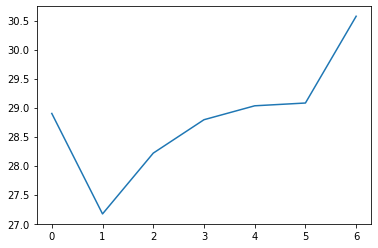

In [97]:
plt.plot(diffs_pc)

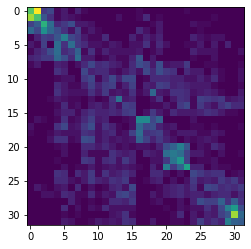

In [90]:
plt.imshow(cm_blanked2)

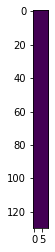

In [46]:
plt.imshow(blanked_pcad1_2)

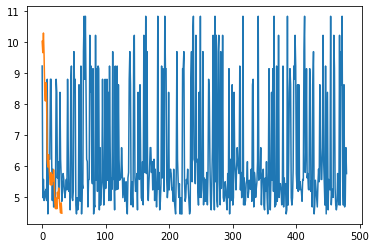

In [25]:
model_bl = blanked_models1[10]
plt.plot(model_bl.pred_resp)
plt.plot(model_bl.pred_train_avg.mean(axis=0))

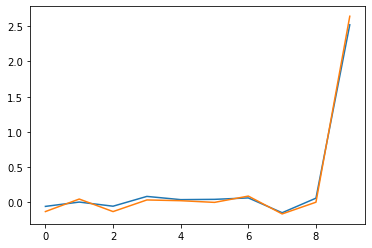

In [104]:
init_ws = model.opt_out.x
model_c = deepcopy(model)
model_c.fit()
plt.plot(init_ws)
plt.plot(model_c.opt_out.x)

In [15]:
pcad_models = deepcopy(full_models1)
pcad_models = np.array(pcad_models)[good_indexes]
scores = []
model = pcad_models[0]
y_full = np.append(model.trial_array, np.ones((32, 1)), axis=1)
default_scores = []
pcad_pred = []
true_resp = []
default_pred = []
for index, model in enumerate(pcad_models):
    
    model.fit(model.X_test_avg[-1], model.trial_array)
    #plt.plot(model.opt_out.x)
    default_scores.append(model.fit_score)
    #print(model.fit_score)
#    default_pred.append(model.pred_resp)
    #print(model.X_test_avg.shape, bins_bl.shape)
#     plt.plot(model.pred_resp)
    model.fit(model.X_test_avg[-1], model.trial_array, W=bins_bl2[index][-1])
    scores.append(model.fit_score)
    pcad_pred.append(model.pred_resp)
    true_resp.append(model.true_resp)
#     plt.plot(model.X_test_avg[0])
#     plt.plot(model.pred_resp)
    #print(model.fit_score)
#     break

def fit_to_reduced_pcs(models, reduced_pc_bins):
    pcad_models = deepcopy(models)
    scores = []
    model = pcad_models[0]
    y_full = np.append(model.trial_array, np.ones((32, 1)), axis=1)
    for index, model in enumerate(pcad_models):

        model.fit(model.X_test_avg[-1], model.trial_array, W=bins_bl2[index][-1])
    return pcad_models
    

NameError: name 'bins_bl2' is not defined

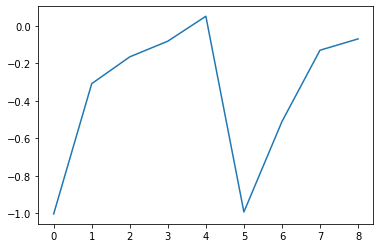

In [121]:
plt.plot(bins_bl[121, 0, :-1])

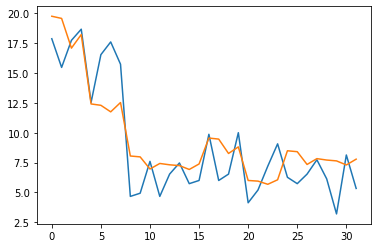

In [137]:
plt.plot(pcad_models[93].X_test_avg[0])

plt.plot(pcad_models[93].pred_resp)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f7d52a0b6d8>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f7d52a0b630>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f7d52a0bc18>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f7d52a0b7f0>}

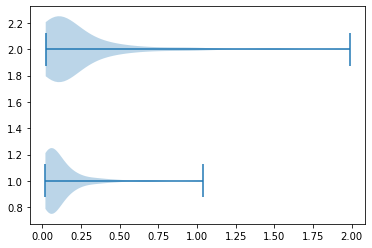

In [138]:

plt.violinplot([default_scores, scores], vert=False)

In [117]:
print(np.where(scores == np.quantile(scores, 0.25, interpolation='nearest')))
print(np.where(scores == np.max(scores)))

(array([93]),)
(array([121]),)


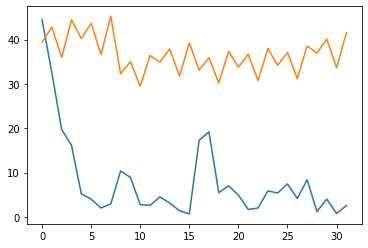

In [48]:
plt.plot(true_resp[121])
plt.plot(pcad_pred[121])

In [87]:
diffs_pcs = [np.sum(abs(cm1-cm_blanked)),
            np.sum(abs(cm1-cm_blanked2)),
            np.sum(abs(cm1-cm_blanked3)),
            np.sum(abs(cm1-cm_blanked4)),
            np.sum(abs(cm1-cm3)),
            np.sum(abs(cm1-))]

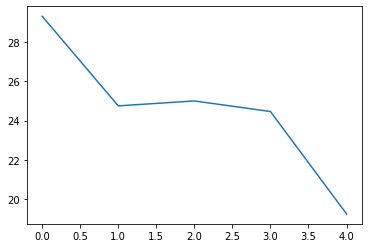

In [88]:
plt.plot(diffs_pcs)

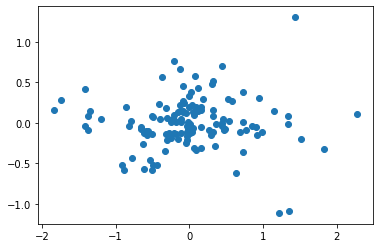

In [139]:
plt.scatter(pcad1[:, 0], pcad1[:, 1])

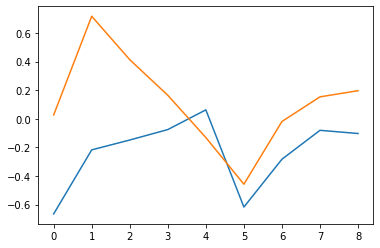

In [84]:
plt.plot(pca1.components_[0])
plt.plot(pca1.components_[1]*-1)

In [21]:
res_uv_bl_15, cm_uv_bl_15 = generate_and_dask(blanked_models1, unit_var_scale=0.15)
print(5)
res_uv_bl_16, cm_uv_bl_16 = generate_and_dask(blanked_models1, unit_var_scale=0.16)
print(6)
res_uv_bl_17, cm_uv_bl_17 = generate_and_dask(blanked_models1, unit_var_scale=0.17)
print(7)
res_uv_bl_18, cm_uv_bl_18 = generate_and_dask(blanked_models1, unit_var_scale=0.18)
print(8)
res_uv_bl_19, cm_uv_bl_19 = generate_and_dask(blanked_models1, unit_var_scale=0.19)
print(9)
res_uv_bl_21, cm_uv_bl_21 = generate_and_dask(blanked_models1, unit_var_scale=0.21)
print(10)
res_uv_bl_22, cm_uv_bl_22 = generate_and_dask(blanked_models1, unit_var_scale=0.22)
print(11)
res_uv_bl_23, cm_uv_bl_23 = generate_and_dask(blanked_models1, unit_var_scale=0.23)
print(12)
res_uv_bl_24, cm_uv_bl_24 = generate_and_dask(blanked_models1, unit_var_scale=0.24)
print(13)
res_uv_bl_25, cm_uv_bl_25 = generate_and_dask(blanked_models1, unit_var_scale=0.25)
print('done')

5
6
7
8
9
10
11
12
13
done


In [134]:
[model.fit(W=blanked_inv)]

In [26]:
diffs_bl = [np.sum(abs(cm1-cm_uv_bl_15)),
           np.sum(abs(cm1-cm_uv_bl_16)),
           np.sum(abs(cm1-cm_uv_bl_17)),
           np.sum(abs(cm1-cm_uv_bl_18)),
           np.sum(abs(cm1-cm_uv_bl_19)),
           np.sum(abs(cm1-cm_blanked)),
           np.sum(abs(cm1-cm_uv_bl_21)),
           np.sum(abs(cm1-cm_uv_bl_22)),
           np.sum(abs(cm1-cm_uv_bl_23)),
           np.sum(abs(cm1-cm_uv_bl_24)),
           np.sum(abs(cm1-cm_uv_bl_25))]

Text(0.5, 0, 'Noise level')

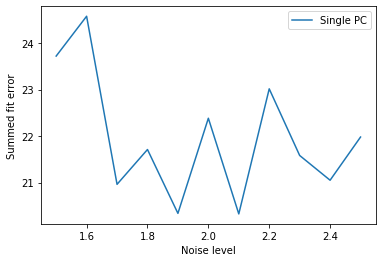

In [28]:
plt.plot([1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5], diffs_bl, label='Single PC')
#plt.plot([1, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 3, 4, 5, 10], diffs, label='Full fitting')
plt.legend()
plt.ylabel('Summed fit error')
plt.xlabel('Noise level')

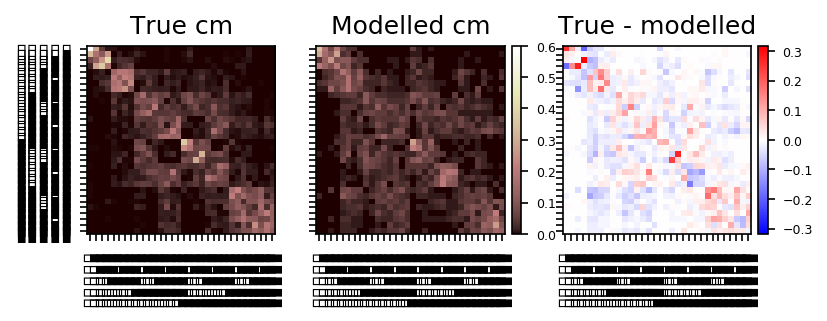

In [50]:
fig = plt.figure(dpi=150)
gs = GridSpec(1, 1)
plot_true_and_heatmap_difference(fig, gs[0], cm1, cm_blanked2)

Text(0.5, 0, 'PC count')

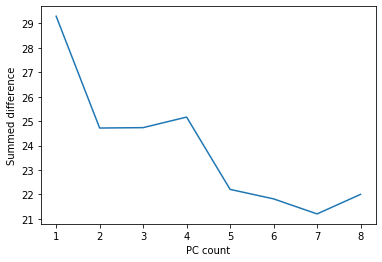

In [48]:
plt.plot(range(1, 9), [np.sum(abs(i - cm1)) for i in [cm_blanked1, cm_blanked2, cm_blanked3, cm_blanked4, cm_blanked5, cm_blanked6, cm_blanked7, cm_blanked8]])
plt.ylabel('Summed difference')
plt.xlabel('PC count')

In [ ]:
model_bl.fit_split()

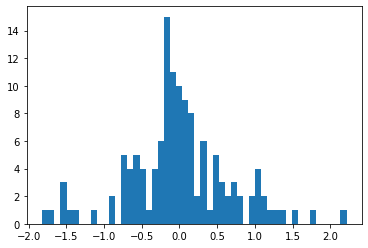

In [159]:
plt.hist(pcad1[:, 0], bins=50);

In [162]:
scipy.stats.kstest(pcad1[:, 0], 'alpha')

TypeError: _parse_args() missing 1 required positional argument: 'a'

In [165]:
logs = scipy.stats.logistic(scipy.stats.logistic.fit(pcad1[:, 0]))

In [166]:
scipy.stats.kstest(pcad1[:, 0], logs)

AxisError: axis -1 is out of bounds for array of dimension 0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import blip_analysis as ba
import exp_blip_models as ebm
import numpy as np
import daskify
from scipy.stats import ttest_ind
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import trange 
import dask
from sklearn.svm import LinearSVC
from scipy.stats import norm

b


In [2]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()

In [4]:
model = diff_models1[0]
dir(model)

['X_test_avg',
 'X_train_avg',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'fit',
 'fit_score',
 'fit_scores',
 'fit_split',
 'fit_withold_trials',
 'is_fit',
 'loss',
 'loss_val',
 'minimisation_loss',
 'opt_out',
 'pred_resp',
 'pred_test_avg',
 'pred_train_avg',
 'test_scores',
 'train_scores',
 'training_opts',
 'trial_array',
 'trial_array_full',
 'true_resp',
 'unit_id',
 'unit_sr',
 'unit_sr_flat',
 'unit_sr_var',
 'unit_srt']